In [1]:
from src.CKANs import *
from src.utils import *
import pickle as pkl
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Example usage you can choose CKANs / CKANs_InceptionBig / CKANs_BigConvs
model = CKANs(input_channels=1, num_classes=3, device=device)

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:

index = np.concatenate([np.arange(3600), np.arange(3600, 10800), np.arange(10800, 14400), np.arange(18000, 21600)])


with open('noisy_csst_images.pkl', 'rb') as f:
    all_images = pkl.load(f)


with open('binned_data_20.pkl', 'rb') as f:
    all_data_params, del_images = pkl.load(f)

del del_images


all_images_array = np.array(all_images)


selected_images = all_images_array[index]


selected_params = {key: np.array(all_data_params[key])[index] for key in ['BCG_e1', 'BCG_e2', 'mass']}

print(f"Selected images shape: {selected_images.shape}")
for key, value in selected_params.items():
    print(f"{key}: shape {value.shape}")


selected_params['bcg_e'] = np.sqrt(selected_params['BCG_e1']**2 + selected_params['BCG_e2']**2)



def get_einstein_radius(cluster_mass, zl=0.3, zs=2.0):
    cluster_mass = cluster_mass * Unit('solMass')
    sigma_crit = sigma_critical(zl, zs, cosmology)
    einstein_rad = np.sqrt(cluster_mass / sigma_crit).to(Unit('Mpc'))
    return einstein_rad.value

mass_array = selected_params['mass']
selected_params['einstein_rad'] = get_einstein_radius(mass_array)



def process_data_noise(images, labels, test_size=0.2, random_state=42):
    X_train, X_val, y_train, y_val, train_idx, val_idx = train_test_split(
        images, labels, np.arange(len(labels)), test_size=test_size, random_state=random_state, stratify=labels
    )
    unique, counts = np.unique(y_train, return_counts=True)
    unique_val, counts_val = np.unique(y_val, return_counts=True)

    return X_train, X_val, y_train, y_val, train_idx, val_idx


labels = np.zeros(18000)
labels[:10800] = 0
labels[10800:14400] = 1
labels[14400:] = 2

X_train, X_val, y_train, y_val, train_idx, val_idx = process_data_noise(selected_images, labels)


def getGenerators_noise(X_train, X_val, y_train, y_val, train_idx, val_idx, meta_data_need=False, meta_data=[]):
    if meta_data_need:
        train_meta = np.stack([selected_params[key][train_idx] for key in meta_data], axis=1)
        val_meta = np.stack([selected_params[key][val_idx] for key in meta_data], axis=1)
    else:
        train_meta = None
        val_meta = None

    train_generator = CustomDataset(X_train, y_train, transform=None, meta_data=train_meta)
    val_generator = CustomDataset(X_val, y_val, transform=None, meta_data=val_meta)
    
    train_loader = DataLoader(train_generator, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_generator, batch_size=32, shuffle=False)
    
    return train_loader, val_loader


train_loader, val_loader = getGenerators_noise(X_train, X_val, y_train, y_val, train_idx, val_idx, meta_data_need=True, meta_data=['bcg_e', 'einstein_rad'])



Selected images shape: (18000, 100, 100, 3)
BCG_e1: shape (18000,)
BCG_e2: shape (18000,)
mass: shape (18000,)
bcg_e 已成功添加到 selected_params 中
einstein_rad 已成功添加到 selected_params 中
训练集每个类别的数量: {np.float64(0.0): np.int64(8640), np.float64(1.0): np.int64(2880), np.float64(2.0): np.int64(2880)}

验证集每个类别的数量: {np.float64(0.0): np.int64(2160), np.float64(1.0): np.int64(720), np.float64(2.0): np.int64(720)}

图像张量形状: torch.Size([32, 100, 100, 3])
标签张量形状: torch.Size([32])
元数据张量形状: torch.Size([32, 2])
cuda
数据集和device加载完毕


In [5]:
def compute_accuracy(data_loader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            meta = batch[2].to(device) if len(batch) > 2 else None
            outputs = model(images, meta)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [6]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, device='cpu'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.CrossEntropyLoss()
        self.model.to(device)

    def train(self, num_epochs=10):
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch in tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                # Extract images, labels, and optionally metadata
                images, labels = batch[0].to(self.device), batch[1].to(self.device)
                meta = batch[2].to(self.device) if len(batch) > 2 else None

                self.optimizer.zero_grad()
                outputs = self.model(images, meta)  # Pass metadata to the model
                loss = self.loss_fn(outputs, labels.long())
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * images.size(0)
            
            epoch_loss = running_loss / len(self.train_loader.dataset)
            val_acc = compute_accuracy(self.val_loader)
            print(f'Loss: {epoch_loss:.4f} | Val Accuracy: {val_acc:.4f}')
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(self.model.state_dict())
        self.model.load_state_dict(best_model_wts)
        print('Training complete.')

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.gridspec import GridSpec



SIDM0_3_images_euclid = all_images[3600:7200]




In [9]:

# bcg_e1_jwst = np.array(all_data_params['BCG_e1'][3600:7200])
# bcg_e2_jwst = np.array(all_data_params['BCG_e2'][3600:7200])
# mass_jwst = np.array(all_data_params['mass'][3600:7200])

bcg_e1_euclid = np.array(all_data_params['BCG_e1'][3600:7200])
bcg_e2_euclid = np.array(all_data_params['BCG_e2'][3600:7200])
mass_euclid = np.array(all_data_params['mass'][3600:7200])


# bcg_e_jwst = np.sqrt(bcg_e1_jwst**2 + bcg_e2_jwst**2)
# einstein_rad_jwst = get_einstein_radius(mass_jwst)


bcg_e_euclid = np.sqrt(bcg_e1_euclid**2 + bcg_e2_euclid**2)
einstein_rad_euclid = get_einstein_radius(mass_euclid)


# metadata_jwst = torch.tensor(np.stack([bcg_e_jwst, einstein_rad_jwst], axis=1), dtype=torch.float32).to(device)
metadata_euclid = torch.tensor(np.stack([bcg_e_euclid, einstein_rad_euclid], axis=1), dtype=torch.float32).to(device)


# SIDM0_3_images_transformed_jwst = torch.tensor(SIDM0_3_images_jwst, dtype=torch.float32).to(device)
SIDM0_3_images_transformed_euclid = torch.tensor(SIDM0_3_images_euclid, dtype=torch.float32).to(device)


# labels_jwst = torch.zeros(SIDM0_3_images_transformed_jwst.size(0), dtype=torch.long).to(device)
labels_euclid = torch.zeros(SIDM0_3_images_transformed_euclid.size(0), dtype=torch.long).to(device)

In [10]:

def evaluate_model(model, images, metadata, labels, batch_size=32):
    correct = 0
    total = 0
    probs = []

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size]
            batch_metadata = metadata[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            outputs = model(batch_images, batch_metadata)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

            probs.append(outputs.cpu().numpy())

    accuracy = correct / total
    return accuracy, np.concatenate(probs, axis=0)

In [13]:
model_name = "CKANs"
epochs = 1
monte_carlo = 10
simulationNames = ['CDM', 'SIDM0.1', 'SIDM1']
nDM_Models = len(simulationNames)
monte_carlo_tests = []
monte_carlo_histories = []
all_probs_jwst = []
all_probs_euclid = []
prob_sidm0_3_jwst = []
prob_sidm0_3_euclid = []






for i in tqdm(range(monte_carlo)):
    set_seed(i)

    
    model = CKAN_Model(input_channels=1, num_classes=3, device=device)
    trainer = Trainer(model, train_loader, val_loader, device=device)
    start = time.time()
    trainer.train(num_epochs=epochs)
    
#     end = time.time()
#     running_time = end-start
#     print('time cost : %.5f sec' %running_time)
    
#     monte_carlo_tests.append(val_loader)
#     monte_carlo_histories.append({'epochs': epochs})
    
#     iDM_model_probs_jwst = []
#     iDM_model_probs_euclid = []



    probabilities_jwst = []
    accuracy_jwst = []
    probabilities_euclid = []
    accuracy_euclid = []



    # acc_jwst, probs_jwst = evaluate_model(model, SIDM0_3_images_transformed_jwst, metadata_jwst, labels_jwst)
    # accuracy_jwst.append(acc_jwst)
    # probabilities_jwst.append(probs_jwst)


    acc_euclid, probs_euclid = evaluate_model(model, SIDM0_3_images_transformed_euclid, metadata_euclid, labels_euclid)
    accuracy_euclid.append(acc_euclid)
    probabilities_euclid.append(probs_euclid)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/450 [00:00<?, ?it/s]

Loss: 0.9504 | Val Accuracy: 0.6000
Training complete.


Epoch 1/1:   0%|          | 0/450 [00:00<?, ?it/s]

Loss: 0.9537 | Val Accuracy: 0.6000
Training complete.


Epoch 1/1:   0%|          | 0/450 [00:00<?, ?it/s]

Loss: 0.9531 | Val Accuracy: 0.6000
Training complete.


Epoch 1/1:   0%|          | 0/450 [00:00<?, ?it/s]

Loss: 0.9453 | Val Accuracy: 0.6000
Training complete.


Epoch 1/1:   0%|          | 0/450 [00:00<?, ?it/s]

Loss: 0.9538 | Val Accuracy: 0.6000
Training complete.


Epoch 1/1:   0%|          | 0/450 [00:00<?, ?it/s]

Loss: 0.9428 | Val Accuracy: 0.6000
Training complete.


Epoch 1/1:   0%|          | 0/450 [00:00<?, ?it/s]

Loss: 0.9456 | Val Accuracy: 0.6000
Training complete.


Epoch 1/1:   0%|          | 0/450 [00:00<?, ?it/s]

Loss: 0.9528 | Val Accuracy: 0.6000
Training complete.


Epoch 1/1:   0%|          | 0/450 [00:00<?, ?it/s]

Loss: 0.9525 | Val Accuracy: 0.6000
Training complete.


Epoch 1/1:   0%|          | 0/450 [00:00<?, ?it/s]

Loss: 0.9399 | Val Accuracy: 0.6000
Training complete.


In [14]:

jwst_filename = "jwst_predictions.pkl"
euclid_filename = "euclid_predictions.pkl"


# with open(jwst_filename, "wb") as f:
#     pkl.dump([probabilities_jwst, accuracy_jwst], f)

with open(euclid_filename, "wb") as f:
    pkl.dump([probabilities_euclid, accuracy_euclid], f)

In [16]:
def get_predictions_per_subset(probability, n_samples_per_subset, cross_sections=[0., 0.1, 1.0], return_weights=False):
    cross_sections = np.array(cross_sections)
    nMonte_carlo = probability.shape[0]
    nClusters = probability.shape[1]
    nDM_Models = probability.shape[2]


    nSubSets = nClusters // n_samples_per_subset
    subset_means, subset_stds, prediction, prediction_err = [], [], [], []

    for iSubSet in range(nSubSets):
        this_subset = np.arange(iSubSet * n_samples_per_subset, min([(iSubSet + 1) * n_samples_per_subset, nClusters]))
        final_probs = np.ones((nMonte_carlo, nDM_Models))

        for iMonteCarlo in range(nMonte_carlo):
            final_probs_per_cluster_per_MC = probability[iMonteCarlo, this_subset, :]
            final_probs_per_cluster_per_MC = final_probs_per_cluster_per_MC / np.sum(final_probs_per_cluster_per_MC, axis=1)[:, np.newaxis]

            for iCluster in range(final_probs_per_cluster_per_MC.shape[0]):
                final_probs[iMonteCarlo] *= final_probs_per_cluster_per_MC[iCluster]
                final_probs[iMonteCarlo] /= np.sum(final_probs[iMonteCarlo])

        final_probs_all = np.mean(final_probs, axis=0)
        print(final_probs_all)
        if return_weights:
            prediction.append(final_probs)
        else:
            pred = np.average(cross_sections, weights=final_probs_all)
            prediction.append(pred)
            prediction_err.append(np.sqrt(np.sum(final_probs_all * (cross_sections - pred) ** 2) / np.sum(final_probs_all) / n_samples_per_subset))

    return np.array(prediction), np.array(prediction_err)

In [17]:
jwst = { 'total':{'ngal_per_sq_arcmin':100}, \
              'xray':{'exposure_time':10_000},
       'nclusters':8}

euclid  = { 'total':{'ngal_per_sq_arcmin':50}, \
              'xray':{'exposure_time':10_000},
          'nclusters':8}


CSST  = { 'total':{'ngal_per_sq_arcmin':80}, \
          'nclusters':8}

# telescopes = [jwst, euclid]
telescopes = [euclid]

[9.98521359e-01 4.31145119e-04 1.04749618e-03]
[9.99998841e-01 1.78947446e-07 9.80131107e-07]
[0.99103945 0.0030279  0.00593265]
[9.99941769e-01 7.68447803e-06 5.05460390e-05]
[9.99935386e-01 2.44468602e-05 4.01670384e-05]
[9.98632987e-01 3.33948351e-04 1.03306445e-03]
[0.99598632 0.00144895 0.00256473]
[9.99817885e-01 8.05544318e-05 1.01560871e-04]
[9.99382674e-01 2.55254308e-04 3.62071431e-04]
[0.9965028  0.00134115 0.00215605]
[9.99711241e-01 8.79037995e-05 2.00855335e-04]
[0.996429   0.00153146 0.00203954]
[9.99679579e-01 1.41342684e-04 1.79078165e-04]
[9.99877154e-01 2.25114878e-05 1.00334056e-04]
[9.99965866e-01 1.30533256e-05 2.10809881e-05]
[9.99440522e-01 2.21672152e-04 3.37805474e-04]
[9.99951053e-01 2.87080478e-05 2.02394220e-05]
[9.99221856e-01 2.58696470e-04 5.19447995e-04]
[9.99932612e-01 3.19216192e-05 3.54660951e-05]
[9.99955163e-01 1.44718959e-05 3.03648442e-05]
[9.99957503e-01 1.38996265e-05 2.85971883e-05]
[9.99987025e-01 3.42147204e-06 9.55333171e-06]
[9.99980462e-0

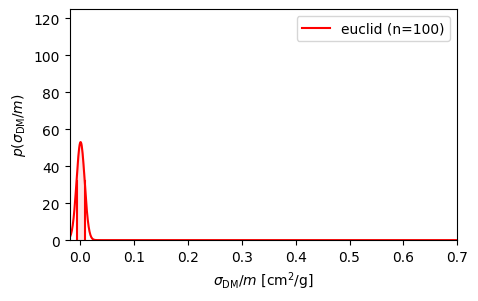

In [18]:
import pickle as pkl

c = ['r','b','g','c','purple']
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
total_clusters = [10,100] #because i have now included nclusters in to the effective galaxy sq arc minute
for i, iT in enumerate(telescopes):
    iSubSample = int(total_clusters[1]/ 12)
    pklfile = "euclid_predictions.pkl"
    # probabilities, accuracy = pkl.load(open(pklfile,"rb")) 
    probabilities = probabilities_euclid
    accuracy = accuracy_euclid
    these_probs = np.exp(np.array(probabilities))
    # print(these_probs)
    these_probs = these_probs/np.sum(these_probs,axis=-1)[:,:,np.newaxis]


    prediction, err = get_predictions_per_subset( these_probs, iSubSample, 
                                                 cross_sections=[0.,0.1,1.], 
                                                 return_weights=False)


    mean = np.nanmedian(prediction)
    std = np.nanmean(err)
    x = np.linspace(-0.1,0.7,1000)
    pdf = norm.pdf(x, mean, std)
    ax.plot(x, pdf, color=c[i])
    if i == 0:
        ylims = ax.get_ylim()
    #ax.plot([mean-std,mean-std],[0,ylims[1]*1.1],'--', color=c[i])
    #ax.plot([mean,mean],[0,ylims[1]*1.1],'--', color=c[i])
    #ax.plot([mean+std,mean+std],[0,ylims[1]*1.1],'--', color=c[i])
    ax.fill_between( x[ (x > mean-std) & (x < mean+std) ], 
                    np.zeros(len(x[ (x > mean-std) & (x < mean+std) ])),
                    pdf[ (x > mean-std) & (x < mean+std) ], color=c[i], alpha=0.1)
    ax.plot( [mean-std,mean-std],[0,norm.pdf(mean-std, mean, std)], '-',color=c[i], \
            label="%s (n=%i)" % ('euclid', total_clusters[1]) )
    ax.plot( [mean+std,mean+std],[0,norm.pdf(mean+std, mean, std)], '-',color=c[i])
    
#ax.set_ylim(0,12)
ax.set_xlim(-0.02,0.7)
#ax.set_xscale('log')
ylim = ax.get_ylim()
#ax.plot([0.1,0.1],[0,ylim[1]*1.1],'k-',label='Blind Truth')
#ax.plot([1,1],[0,ylim[1]*1.1],'k-',label='Blind Truth')
ax.set_ylim(0,125)
ax.legend(loc=1)
ax.set_xlabel(r'$\sigma_{\rm DM}/m$ [cm$^2$/g]')
ax.set_ylabel(r'$p(\sigma_{\rm DM}/m)$')

plt.savefig("euclid_results.pdf")